In [ ]:
# | hide
# skip
! [ -e /content ] && pip install -Uqq model_inspector nbdev
# For colab. Restart the runtime after running this cell!

In [ ]:
# | default_exp get_inspector

# Get an Inspector

> Get an appropriate inspector for your model

In [ ]:
# | export
import pandas as pd
from model_inspector.inspect.any_model import _Inspector
from model_inspector.inspect.classifier import _BinInspector, _MultiInspector
from model_inspector.inspect.linear_model import (
    _LinRegInspector,
    _LinBinInspector,
    _LinMultiInspector,
)
from model_inspector.inspect.regressor import _RegInspector
from model_inspector.inspect.searchcv_estimator import _SearchCVInspector
from model_inspector.inspect.tree import (
    _TreeRegInspector,
    _TreeBinInspector,
    _TreeMultiInspector,
)
from sklearn.base import BaseEstimator
from sklearn.linear_model._base import (
    LinearClassifierMixin,
    LinearModel,
    RegressorMixin,
)
from sklearn.model_selection._search import BaseSearchCV
from sklearn.tree import BaseDecisionTree
from sklearn.utils.multiclass import type_of_target

In [ ]:
# | export
def get_inspector(model: BaseEstimator, X: pd.DataFrame, y: pd.Series) -> _Inspector:
    """Get an appropriate inspector for your model and data.

    Parameters:

    - `model`: Fitted sklearn model
    - `X`: Matrix with the same features `model` was trained on
    - `y`: Series with same length as `X` and same meaning as target
    values `model` was trained on
    """
    if isinstance(model, LinearModel):
        return _LinRegInspector(model, X, y)
    elif isinstance(model, LinearClassifierMixin):
        if type_of_target(y) == "binary":
            return _LinBinInspector(model, X, y)
        elif type_of_target(y) == "multiclass":
            return _LinMultiInspector(model, X, y)
    elif isinstance(model, BaseDecisionTree):
        # `type_of_target` can't reliably distinguish between continuous and
        # multiclass
        if isinstance(model, RegressorMixin):
            return _TreeRegInspector(model, X, y)
        elif type_of_target(y) == "binary":
            return _TreeBinInspector(model, X, y)
        elif type_of_target(y) == "multiclass":
            return _TreeMultiInspector(model, X, y)
    elif isinstance(model, BaseSearchCV):
        return _SearchCVInspector(model, X, y)
    # `type_of_target` can't reliably distinguish between continuous and
    # multiclass
    if isinstance(model, RegressorMixin):
        return _RegInspector(model, X, y)
    elif type_of_target(y) == "binary":
        return _BinInspector(model, X, y)
    elif type_of_target(y) == "multiclass":
        return _MultiInspector(model, X, y)
    else:
        return _Inspector(model, X, y)

In [ ]:
# | hide
import sklearn.datasets
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [ ]:
# | hide
X_diabetes, y_diabetes = sklearn.datasets.load_diabetes(return_X_y=True, as_frame=True)
X_breast_cancer, y_breast_cancer = sklearn.datasets.load_breast_cancer(
    return_X_y=True, as_frame=True
)
X_iris, y_iris = sklearn.datasets.load_iris(return_X_y=True, as_frame=True)

for model, inspector_class, X, y in [
    (LinearRegression(), _LinRegInspector, X_diabetes, y_diabetes),
    (DecisionTreeRegressor(), _TreeRegInspector, X_diabetes, y_diabetes),
    (SVR(), _RegInspector, X_diabetes, y_diabetes),
    (GridSearchCV(LinearRegression(), {}), _SearchCVInspector, X_diabetes, y_diabetes),
    (
        LogisticRegression(max_iter=10_000),
        _LinBinInspector,
        X_breast_cancer,
        y_breast_cancer,
    ),
    (DecisionTreeClassifier(), _TreeBinInspector, X_breast_cancer, y_breast_cancer),
    (SVC(), _BinInspector, X_breast_cancer, y_breast_cancer),
    (LogisticRegression(max_iter=10_000), _LinMultiInspector, X_iris, y_iris),
    (DecisionTreeClassifier(), _TreeMultiInspector, X_iris, y_iris),
    (SVC(), _MultiInspector, X_iris, y_iris),
]:
    assert isinstance(get_inspector(model.fit(X, y), X, y), inspector_class)

Example:

In [ ]:
import sklearn.datasets
from sklearn.tree import DecisionTreeRegressor
from model_inspector import get_inspector

In [ ]:
X, y = sklearn.datasets.load_diabetes(return_X_y=True, as_frame=True)

In [ ]:
dtr = DecisionTreeRegressor().fit(X, y)

In [ ]:
inspector = get_inspector(dtr, X=X, y=y)
inspector

model_inspector.inspect.tree._TreeRegInspector(model=DecisionTreeRegressor())

In [ ]:
inspector.methods

['permutation_importance',
 'plot_feature_clusters',
 'plot_partial_dependence',
 'plot_permutation_importance',
 'plot_pred_vs_act',
 'plot_residuals',
 'plot_tree',
 'show_correlation']

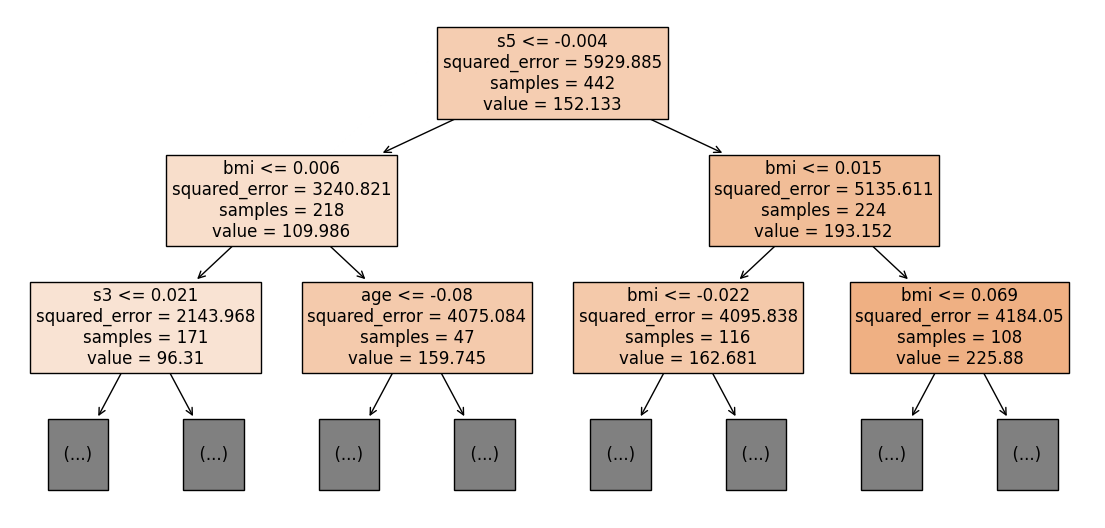

In [ ]:
ax = inspector.plot_tree(max_depth=2)